## Schliersee und Tegernsee



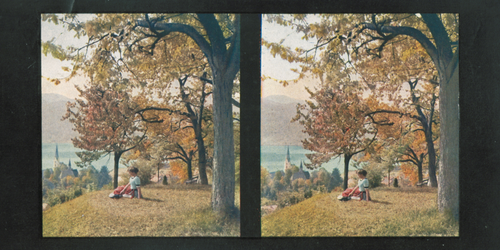




Wikidata link: [http://www.wikidata.org/entity/Q118720298](http://www.wikidata.org/entity/Q118720298)

Materials: cardboard

Year: 1907

Location: Adolf-Würth-Zentrum für Geschichte der Psychologie

## [Mainufer in Würzburg]



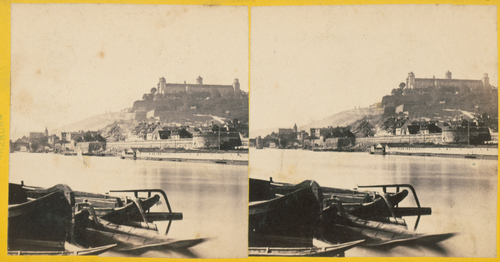




Wikidata link: [http://www.wikidata.org/entity/Q118720301](http://www.wikidata.org/entity/Q118720301)

Materials: cardboard, albumin paper

Year: 1860

Location: Adolf-Würth-Zentrum für Geschichte der Psychologie

## Dolomiten II



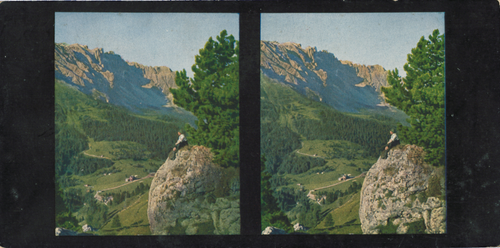




Wikidata link: [http://www.wikidata.org/entity/Q118720297](http://www.wikidata.org/entity/Q118720297)

Materials: cardboard

Year: 1907

Location: Adolf-Würth-Zentrum für Geschichte der Psychologie

## Mondkugel



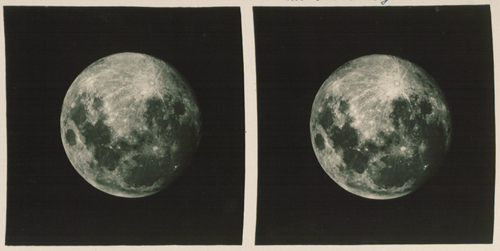




Wikidata link: [http://www.wikidata.org/entity/Q118720299](http://www.wikidata.org/entity/Q118720299)

Materials: photographic paper

Year: N/A

Location: Adolf-Würth-Zentrum für Geschichte der Psychologie

## Die Kaisergalerie



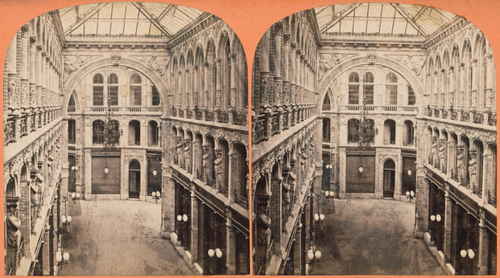




Wikidata link: [http://www.wikidata.org/entity/Q118720300](http://www.wikidata.org/entity/Q118720300)

Materials: cardboard, albumin paper

Year: 1864

Location: Adolf-Würth-Zentrum für Geschichte der Psychologie



In [2]:
from SPARQLWrapper import SPARQLWrapper, JSON
from PIL import Image
import requests

# VARIABLES

sparql_endpoint_url = 'https://query.wikidata.org/bigdata/namespace/wdq/sparql'
wikibase_url = 'https://www.wikidata.org'
api_url = '/w/api.php'

# Wikidata requires a user agent header to prevent spam requests
user_agent = 'Ex_Books_conference_bot/0.0 (https://github.com/SimonXIX/Experimental_Books_workshop; ad7588@coventry.ac.uk)'

# SPARQL query
# see in Wikidata's Query Service GUI at:
# https://w.wiki/6dZ3
query = """
SELECT DISTINCT ?item ?itemLabel ?cites_work ?locationLabel ?colorLabel ?material ?year WHERE {
  SERVICE wikibase:label { bd:serviceParam wikibase:language "de". }  
  ?item wdt:P276 wd:Q55752747.
  OPTIONAL { ?item wdt:P18 ?cites_work. }
  OPTIONAL { ?item wdt:P276 ?location. }
  OPTIONAL { ?item wdt:P462 ?color. }
  {
    SELECT ?item (group_concat(?made_from_materialLabel; separator = "; ") as ?material) WHERE { 
            ?item wdt:P276 wd:Q55752747.
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en".               
                          ?made_from_material rdfs:label ?made_from_materialLabel.
 }

      ?item wdt:P186 ?made_from_material. 
    }
    GROUP BY ?item ?itemLabel
  
  }
  OPTIONAL { ?item wdt:P571 ?inception. BIND(year(?inception) as ?inceptionyear) }
  OPTIONAL { ?item wdt:P580 ?start. BIND(year(?start) as ?startyear) }
  BIND(COALESCE(?inceptionyear, ?startyear) as ?year)
  }

"""



# SUBROUTINES

def get_delay(date):
    try:
        date = datetime.datetime.strptime(date, '%a, %d %b %Y %H:%M:%S GMT')
        timeout = int((date - datetime.datetime.now()).total_seconds())
    except ValueError:
        timeout = int(date)
    return timeout

def get_image(url, headers):
    r = requests.get(url, headers=headers, stream=True)
    if r.status_code == 200:
        im = Image.open(r.raw)
        return im
    if r.status_code == 500:
        return None
    if r.status_code == 403:
        return None
    if r.status_code == 429:
        timeout = get_delay(r.headers['retry-after'])
        print('Timeout {} m {} s'.format(timeout // 60, timeout % 60))
        time.sleep(timeout)
        get_image(url, headers)

# MAIN PROGRAM

# create SPARQL query
sparql = SPARQLWrapper(sparql_endpoint_url, agent=user_agent)

# retrieve results and convert to JSON format
sparql.setQuery(query)
sparql.setReturnFormat(JSON)
result = sparql.query().convert()

# for each result, print various data fields
for item in result['results']['bindings']:
    
    print('## ' + item['itemLabel']['value'] + '\n')

    # get image from image URL and display resized version
    image_url=item['cites_work']['value']
    headers = {'User-Agent': 'Ex_Books_conference_bot/0.0 (https://github.com/SimonXIX/Experimental_Books_workshop; ad7588@coventry.ac.uk)'}
    im = get_image(image_url, headers)
    im.thumbnail((500, 500), Image.Resampling.LANCZOS)
    display(im)
    
    print('\n\n')
    
    print('Wikidata link: ' + '[' + item['item']['value'] + ']' + '(' + item['item']['value'] + ')' + '\n')
    
    if 'material' in item:
        materials = item['material']['value'].split("; ")

    
    print('Materials: ' + ', '.join(materials) + '\n')
    #print('Material: ' + item['made_from_materialLabel']['value'] + '\n')
    if 'year' in item:
        year = item['year']['value']
    else:
        year = 'N/A'
    
    print('Year: ' + year + '\n')
    print('Location: ' + item['locationLabel']['value'] + '\n')
    
